# **Imports and Load Dependences**


In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.0 MB/s eta 0:00:00


In [2]:
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import plotly.graph_objects as go
import plotly.express as px

# Function to remove special characters
from unidecode import unidecode

from tqdm.notebook import tqdm, trange

# Feature Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Feature Importance
from sklearn.feature_selection import mutual_info_classif, chi2


my_palette = sns.diverging_palette(230, 20, as_cmap=False)
sns.set_theme(style="ticks", palette=my_palette)

# **Load Datasets**

In [3]:
#@title Download Datasets from GDrive

# ESC RENDA
!gdown 1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO

# Cities Frame
!gdown 1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ

Downloading...
From: https://drive.google.com/uc?id=1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO
To: /content/RAIS_IBGE_RENDA.csv
100% 1.64M/1.64M [00:00<00:00, 174MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ
To: /content/results_scrapper_PCDII.csv
100% 698k/698k [00:00<00:00, 97.1MB/s]


In [16]:
# Economic Level
!gdown 1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ

Downloading...
From: https://drive.google.com/uc?id=1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ
To: /content/results_scrapper_PCDII.csv
100% 698k/698k [00:00<00:00, 113MB/s]


In [4]:
df = pd.read_csv('RAIS_IBGE_RENDA.csv', encoding='ISO-8859-1', sep=';')

cities_df = pd.read_csv('results_scrapper_PCDII.csv', index_col=0)

In [17]:
nve_df = pd.read_csv('results_scrapper_PCDII.csv', index_col=0)
nve_df.columns = [key.replace(' ','_').capitalize() for key in nve_df.columns]

# **Pre-Processing**

## **ESC FREQ**

In [5]:
#@title Show attributes types and evaluate the existence of NaN values in each feature
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NO_MUNICIPIO                5570 non-null   object 
 1   Extrativa Mineral           5570 non-null   float64
 2   Prod. Mineral Não Metálico  5570 non-null   float64
 3   Indústria Metalúrgica       5570 non-null   float64
 4   Indústria Mecânica          5570 non-null   float64
 5   Elétrico e Comunic          5570 non-null   float64
 6   Material de Transporte      5570 non-null   float64
 7   Madeira e Mobiliário        5570 non-null   float64
 8   Papel e Gráf                5570 non-null   float64
 9   Borracha. Fumo. Couros      5570 non-null   float64
 10  Indústria Química           5570 non-null   float64
 11  Indústria Têxtil            5570 non-null   float64
 12  Indústria Calçados          5570 non-null   float64
 13  Alimentos e Bebidas         5570 

In [6]:
#@title Describe dataset with summary measures
#@markdown The idea is to evaluate the existence of different scales beetwen the features
#@markdown - Presence of outliers or influence of larger cities?
df.describe()

,Extrativa Mineral,Prod. Mineral Não Metálico,Indústria Metalúrgica,Indústria Mecânica,Elétrico e Comunic,Material de Transporte,Madeira e Mobiliário,Papel e Gráf,Borracha. Fumo. Couros,Indústria Química,...,Instituição Financeira,Adm Técnica Profissional,Transporte e Comunicações,Aloj Comunic,Médicos Odontológicos Vet,Ensino,Administração Pública,Agricultura,Outros. ignorados,Total
count,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,...,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03
mean,4.876098e+03,2.198172e+03,2.995202e+03,4.494362e+03,1.185695e+03,1.031073e+03,1.558945e+03,2.105145e+03,1.616080e+03,2.266732e+03,...,1.862408e+04,3.724353e+03,5.183047e+03,5.066708e+03,3.663428e+03,3.125926e+03,3.988332e+03,4.236585e+03,1.046613e+04,3.075115e+03
std,1.324970e+05,4.116785e+04,6.902714e+04,1.528453e+05,2.964154e+04,2.389436e+04,3.184308e+04,4.743371e+04,4.181082e+04,4.836874e+04,...,3.616998e+05,5.157208e+04,8.020668e+04,6.825873e+04,5.853966e+04,4.924064e+04,5.218790e+04,5.806879e+04,4.023340e+05,3.397596e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.185183e+03
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.236456e+03,1.266042e+03,1.943035e+03,1.254997e+03,9.021175e+02,0.000000e+00,2.428586e+03,1.295923e+03,0.000000e+00,2.178938e+03
50%,0.000000e+00,1.234355e+03,1.107517e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.151400e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,9.555876e+03,1.635749e+03,2.376843e+03,1.489494e+03,1.460158e+03,1.239107e+03,2.877390e+03,1.665530e+03,0.000000e+00,2.492827e+03
75%,2.049328e+03,1.777078e+03,1.833848e+03,1.813480e+03,0.000000e+00,0.000000e+00,1.735244e+03,1.349493e+03,1.332254e+03,1.802701e+03,...,1.631462e+04,2.084053e+03,3.125930e+03,1.777774e+03,2.098142e+03,1.814378e+03,3.425168e+03,2.138780e+03,8.955993e+02,2.874330e+03
max,6.500125e+06,1.982125e+06,4.130766e+06,1.065719e+07,1.693375e+06,1.266972e+06,2.019429e+06,1.833875e+06,2.028625e+06,2.660255e+06,...,2.297233e+07,1.849468e+06,3.693375e+06,1.845375e+06,2.277884e+06,1.679125e+06,3.203212e+06,1.769994e+06,2.719288e+07,2.537721e+06


In [7]:
#@title View dataset struct
df.head()

,NO_MUNICIPIO,Extrativa Mineral,Prod. Mineral Não Metálico,Indústria Metalúrgica,Indústria Mecânica,Elétrico e Comunic,Material de Transporte,Madeira e Mobiliário,Papel e Gráf,Borracha. Fumo. Couros,...,Instituição Financeira,Adm Técnica Profissional,Transporte e Comunicações,Aloj Comunic,Médicos Odontológicos Vet,Ensino,Administração Pública,Agricultura,Outros. ignorados,Total
0,RO-ALTA FLORESTA D OESTE,8303.596429,1460.834400,1139.901667,1156.502000,1.187310e+03,0.000000,1435.412623,0.000000,0.000000,...,11756.227571,2691.283758,1906.973068,1404.867901,1472.931618,1449.643750,2839.320826,1808.425323,1507.000,2680.309326
1,RO-ARIQUEMES,4025.958337,1637.429291,2174.320311,1638.107812,1.578153e+03,1983.119180,1805.707969,1759.904063,1696.396204,...,10175.128620,1933.572561,2239.654572,1447.278952,1955.147011,2023.770987,4343.577017,2167.645788,0.000,2725.849126
2,RO-CABIXI,0.000000,1210.654091,1539.130000,2000.000000,0.000000e+00,0.000000,1058.972059,0.000000,0.000000,...,8594.757143,1995.974444,1760.351739,1238.737500,616.595714,1829.220000,2785.756043,2371.936096,3920.000,2325.052838
3,RO-CACOAL,2379.247241,1615.921755,1486.301940,1455.250000,1.348625e+06,2165.491034,1600.382452,1674.835135,3297.341124,...,10437.607188,1853.386706,2089.586316,1515.685541,2192.753868,2626.713299,4142.563195,1590.851946,781.275,2449.671511
4,RO-CEREJEIRAS,0.000000,1664.870000,1292.188000,1214.023000,0.000000e+00,1405.800000,1864.167045,1752.980909,1402.720000,...,12750.547015,1895.252798,1831.296263,1470.756693,1452.672000,1304.309231,2924.560581,2615.207959,55935.640,2879.817039


In [8]:
#@title Rename dataset keys
#@markdown Remove special characters from the features names

df = df.rename(columns={key: unidecode(key).replace(' ', '_') for key in df.keys()})

In [10]:
df

,NO_MUNICIPIO,Extrativa_Mineral,Prod._Mineral_Nao_Metalico,Industria_Metalurgica,Industria_Mecanica,Eletrico_e_Comunic,Material_de_Transporte,Madeira_e_Mobiliario,Papel_e_Graf,Borracha._Fumo._Couros,...,Instituicao_Financeira,Adm_Tecnica_Profissional,Transporte_e_Comunicacoes,Aloj_Comunic,Medicos_Odontologicos_Vet,Ensino,Administracao_Publica,Agricultura,Outros._ignorados,Total
0,RO-ALTA FLORESTA D OESTE,8303.596429,1460.834400,1139.901667,1156.502000,1.187310e+03,0.000000,1435.412623,0.000000,0.000000,...,11756.227571,2691.283758,1906.973068,1404.867901,1472.931618,1449.643750,2839.320826,1808.425323,1507.000000,2680.309326
1,RO-ARIQUEMES,4025.958337,1637.429291,2174.320311,1638.107812,1.578153e+03,1983.119180,1805.707969,1759.904063,1696.396204,...,10175.128620,1933.572561,2239.654572,1447.278952,1955.147011,2023.770987,4343.577017,2167.645788,0.000000,2725.849126
2,RO-CABIXI,0.000000,1210.654091,1539.130000,2000.000000,0.000000e+00,0.000000,1058.972059,0.000000,0.000000,...,8594.757143,1995.974444,1760.351739,1238.737500,616.595714,1829.220000,2785.756043,2371.936096,3920.000000,2325.052838
3,RO-CACOAL,2379.247241,1615.921755,1486.301940,1455.250000,1.348625e+06,2165.491034,1600.382452,1674.835135,3297.341124,...,10437.607188,1853.386706,2089.586316,1515.685541,2192.753868,2626.713299,4142.563195,1590.851946,781.275000,2449.671511
4,RO-CEREJEIRAS,0.000000,1664.870000,1292.188000,1214.023000,0.000000e+00,1405.800000,1864.167045,1752.980909,1402.720000,...,12750.547015,1895.252798,1831.296263,1470.756693,1452.672000,1304.309231,2924.560581,2615.207959,55935.640000,2879.817039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,GO-VIANOPOLIS,0.000000,1755.625937,1900.890294,1580.950000,1.502133e+03,0.000000,1488.698333,1226.812000,0.000000,...,23292.701837,2009.067079,2122.636074,1512.958655,1635.030784,1334.664545,4025.166040,2166.644556,12272.510000,2836.432798
5566,GO-VICENTINOPOLIS,1447.758000,0.000000,2379.817692,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,31474.148750,2055.186094,2498.991887,1081.362984,1451.850000,2577.130000,3141.499003,2270.617322,5533.200000,2861.243147
5567,GO-VILA BOA,1605.386667,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,1868.802750,4101.440000,1354.493276,0.000000,4623.022556,2373.315771,871.500037,0.000000,1543.653622
5568,GO-VILA PROPICIO,4311.400440,1070.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,1409.367407,2005.517500,1432.612075,2292.301098,2705.225238,2500.588721,2068.231363,0.000000,2600.394510


In [12]:
#@title Get state and city in dataframe
#@markdown Separate State and City from the Municipio attribute

def format_city(city: str):

  city_without_special_charac = unidecode(city)

  city_capitalize = city_without_special_charac.capitalize()

  return city_capitalize


state_and_city_frame = df['NO_MUNICIPIO'].apply(lambda x: x.split('-'))

state = []
city = []

for row in state_and_city_frame:
  state.append(row[0])
  city.append(format_city(row[1]))

# Replace Municipio feature
df['NO_MUNICIPIO'] = city

# Create Estato feature
df['Estado'] = state

# Reorder the columns
df = df[df.columns[-1:].tolist() + df.columns[:-1].tolist()]

In [13]:
df.head()

,Estado,NO_MUNICIPIO,Extrativa_Mineral,Prod._Mineral_Nao_Metalico,Industria_Metalurgica,Industria_Mecanica,Eletrico_e_Comunic,Material_de_Transporte,Madeira_e_Mobiliario,Papel_e_Graf,...,Instituicao_Financeira,Adm_Tecnica_Profissional,Transporte_e_Comunicacoes,Aloj_Comunic,Medicos_Odontologicos_Vet,Ensino,Administracao_Publica,Agricultura,Outros._ignorados,Total
0,RO,Alta floresta d oeste,8303.596429,1460.834400,1139.901667,1156.502000,1.187310e+03,0.000000,1435.412623,0.000000,...,11756.227571,2691.283758,1906.973068,1404.867901,1472.931618,1449.643750,2839.320826,1808.425323,1507.000,2680.309326
1,RO,Ariquemes,4025.958337,1637.429291,2174.320311,1638.107812,1.578153e+03,1983.119180,1805.707969,1759.904063,...,10175.128620,1933.572561,2239.654572,1447.278952,1955.147011,2023.770987,4343.577017,2167.645788,0.000,2725.849126
2,RO,Cabixi,0.000000,1210.654091,1539.130000,2000.000000,0.000000e+00,0.000000,1058.972059,0.000000,...,8594.757143,1995.974444,1760.351739,1238.737500,616.595714,1829.220000,2785.756043,2371.936096,3920.000,2325.052838
3,RO,Cacoal,2379.247241,1615.921755,1486.301940,1455.250000,1.348625e+06,2165.491034,1600.382452,1674.835135,...,10437.607188,1853.386706,2089.586316,1515.685541,2192.753868,2626.713299,4142.563195,1590.851946,781.275,2449.671511
4,RO,Cerejeiras,0.000000,1664.870000,1292.188000,1214.023000,0.000000e+00,1405.800000,1864.167045,1752.980909,...,12750.547015,1895.252798,1831.296263,1470.756693,1452.672000,1304.309231,2924.560581,2615.207959,55935.640,2879.817039


In [15]:
df = df.rename(columns={'NO_MUNICIPIO':'Municipio'})

## **Economic Level Frame**

In [18]:
# Get state in name feature
nve_df['Estado'] = nve_df['Nome'].str.extract(r'\((.*?)\)')

# Get name of city in name feature
nve_df['Municipio'] = nve_df['Nome'].str.extract(r'^(.*?)(?:\s\()')

# Standardizes the names of cities
nve_df['Municipio'] = nve_df['Municipio'].apply(lambda x : format_city(x))

# **EDA Dataset Attributes**

## **Original Data Variable Analyze**

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Estado                      5570 non-null   object 
 1   Municipio                   5570 non-null   object 
 2   Extrativa_Mineral           5570 non-null   float64
 3   Prod._Mineral_Nao_Metalico  5570 non-null   float64
 4   Industria_Metalurgica       5570 non-null   float64
 5   Industria_Mecanica          5570 non-null   float64
 6   Eletrico_e_Comunic          5570 non-null   float64
 7   Material_de_Transporte      5570 non-null   float64
 8   Madeira_e_Mobiliario        5570 non-null   float64
 9   Papel_e_Graf                5570 non-null   float64
 10  Borracha._Fumo._Couros      5570 non-null   float64
 11  Industria_Quimica           5570 non-null   float64
 12  Industria_Textil            5570 non-null   float64
 13  Industria_Calcados          5570 

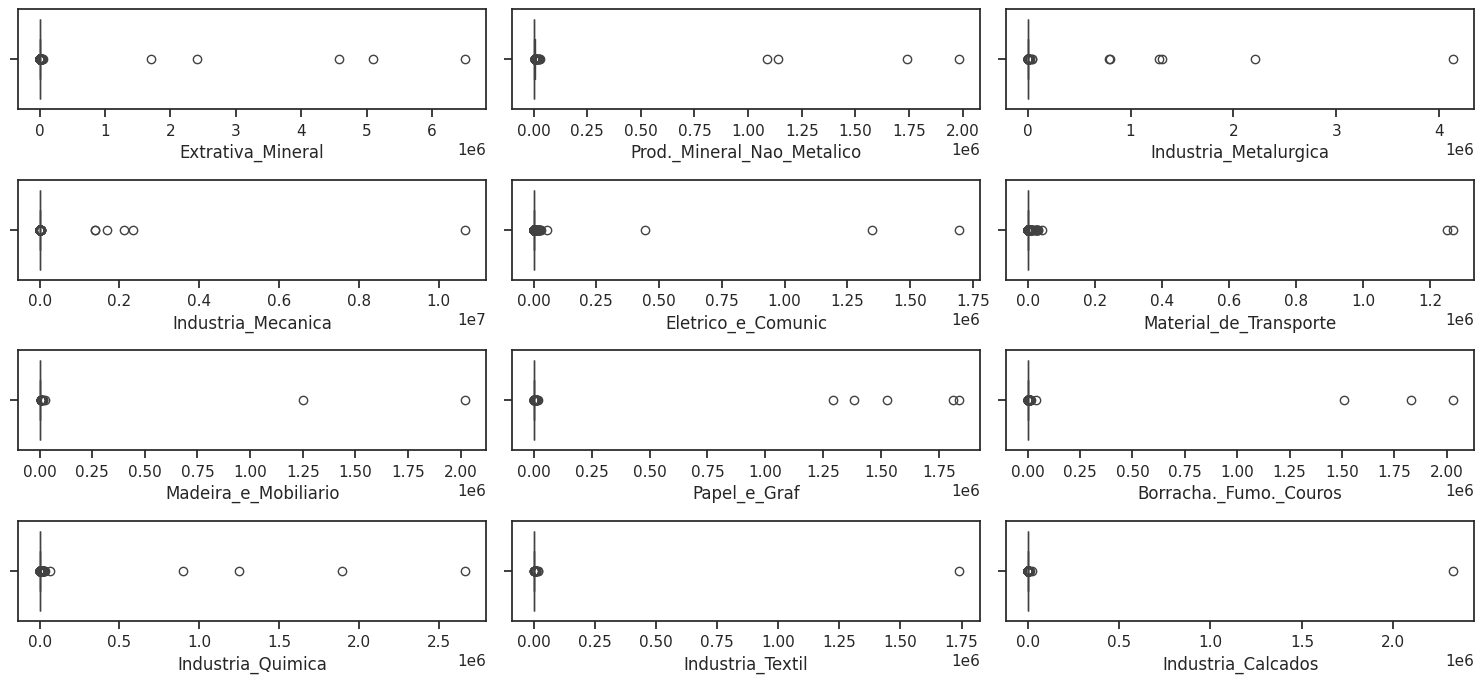

In [20]:
#@markdown Analyze outliers with a BoxPlot
numeric_features = list(df.keys())[2:]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 7))
axs = axs.flatten()

for key, ax in zip(numeric_features, axs):
  sns.boxplot(df, x=key, ax=ax)

plt.tight_layout()
plt.show()

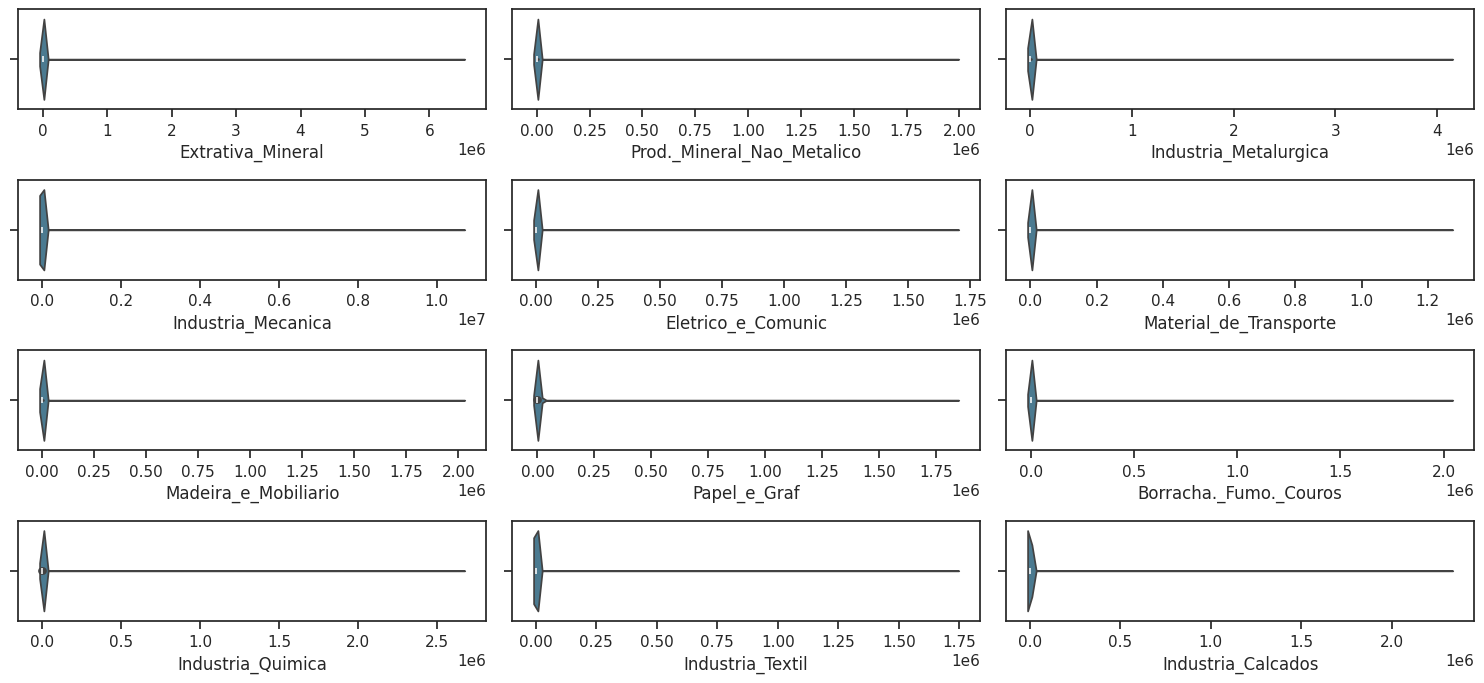

In [21]:
#@markdown Analize data distribution and outliers with a violin plot

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 7))
axs = axs.flatten()

for key, ax in zip(numeric_features, axs):
  sns.violinplot(df, x=key, ax=ax)

plt.tight_layout()
plt.show()

In [22]:
#@title ## Create new dataset without outliers
def remove_outliers_iqr(df: pd.DataFrame):
    # Compute Quantilies
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Compute IQR
    IQR = Q3 - Q1

    # Define upper and lower limits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply filter in dataset
    df_filtered = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

    return df_filtered

df_without_outliers = remove_outliers_iqr(df.iloc[:,2:])

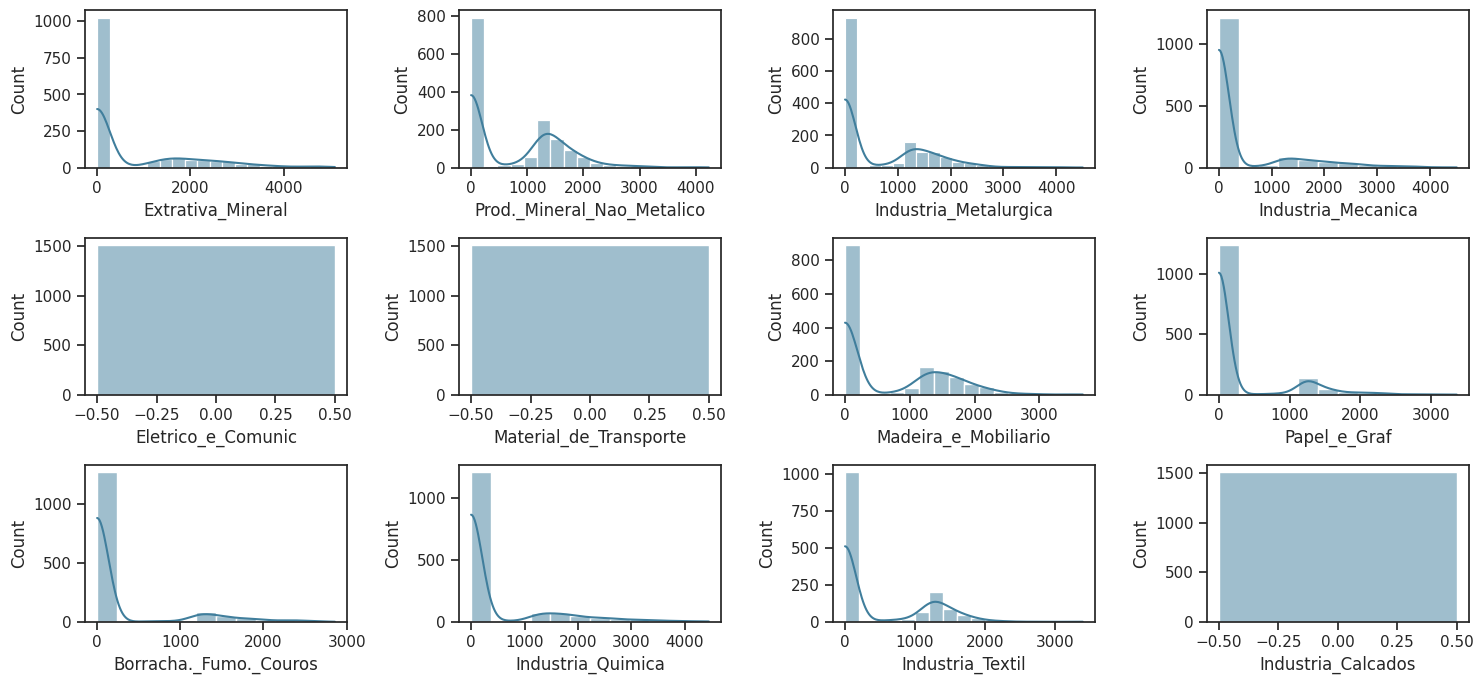

In [23]:
#@markdown Analyze the data distribution with a histogram plot
#@markdown - We can see distrubrion forms like Gamma distribution

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 7))
axs = axs.flatten()

for key, ax in zip(numeric_features, axs):
  sns.histplot(df_without_outliers, x=key, ax=ax, kde=True)

plt.tight_layout()
plt.show()

## **Creating Groups fom Quartiles**

Criar grupos a partir dos quantils da variavel total, que é a soma de todas as outras variaveis

In [24]:
target = 'Total' #@param
num_quantiles = 4 #@param

initial_percentage_of_the_quantilies = 1 / (num_quantiles)
percentage_of_the_quantilies = np.arange(0, 1, initial_percentage_of_the_quantilies)[1:]
print(f'Quantis Observados', percentage_of_the_quantilies)

VALUES_OF_THE_QUANTILES = df[target].quantile(q=percentage_of_the_quantilies).to_numpy()
print(f'Valores de limiar usados', VALUES_OF_THE_QUANTILES)

def define_quantile_group(x):

  for group_index, threshold in enumerate(VALUES_OF_THE_QUANTILES):

    if x < threshold:
      return group_index

  return group_index + 1

df['Group'] = df[target].apply(lambda x : define_quantile_group(x))

Quantis Observados [0.25 0.5  0.75]
Valores de limiar usados [2178.93839541 2492.82666486 2874.32972002]


Atributos e Indice
{'Adm_Tecnica_Profissional': 20,
 'Administracao_Publica': 25,
 'Agricultura': 26,
 'Alimentos_e_Bebidas': 14,
 'Aloj_Comunic': 22,
 'Borracha._Fumo._Couros': 10,
 'Comercio_Atacadista': 18,
 'Comercio_Varejista': 17,
 'Construcao_Civil': 16,
 'Eletrico_e_Comunic': 6,
 'Ensino': 24,
 'Estado': 0,
 'Extrativa_Mineral': 2,
 'Group': 29,
 'Industria_Calcados': 13,
 'Industria_Mecanica': 5,
 'Industria_Metalurgica': 4,
 'Industria_Quimica': 11,
 'Industria_Textil': 12,
 'Instituicao_Financeira': 19,
 'Madeira_e_Mobiliario': 8,
 'Material_de_Transporte': 7,
 'Medicos_Odontologicos_Vet': 23,
 'Municipio': 1,
 'Outros._ignorados': 27,
 'Papel_e_Graf': 9,
 'Prod._Mineral_Nao_Metalico': 3,
 'Servico_Utilidade_Publica': 15,
 'Total': 28,
 'Transporte_e_Comunicacoes': 21}


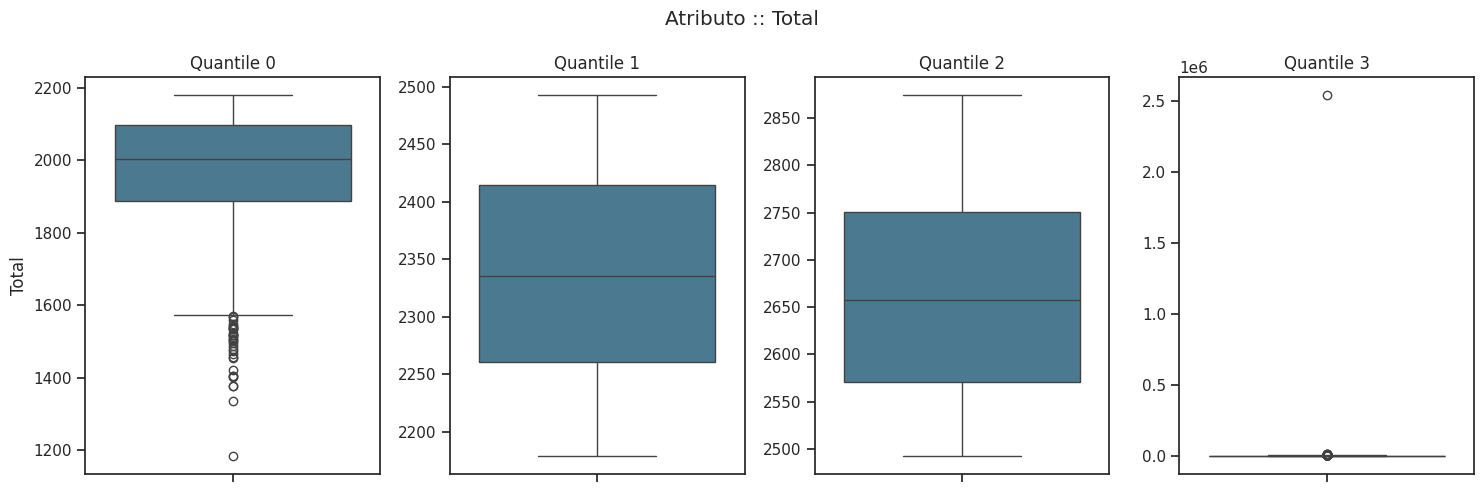

In [29]:
#@markdown Analyze outliers with a BoxPlot
from pprint import pprint

feature_index = 28 #@param

key = list(df.keys())[feature_index]
dict_feature_name_idx = {feature_name: idx for idx, feature_name in enumerate(df.keys())}

print(f'Atributos e Indice')
pprint(dict_feature_name_idx)

fig, axs = plt.subplots(ncols=num_quantiles, figsize=(15, 5))

for group_index in range(num_quantiles):
  sns.boxplot(df[df['Group'] == group_index], y=key, ax=axs[group_index])
  axs[group_index].set_title(f'Quantile {group_index}')

  if group_index > 0:
    axs[group_index].set_ylabel('')

treated_key = key.capitalize().replace('_', ' ')
plt.suptitle(f'Atributo :: {treated_key}')
plt.tight_layout()
plt.show()

## **Remove selected outliers $\to$ "Metropolis"**

In [30]:
df[['Municipio', 'Total']].sort_values(by=['Total'], ascending=False).head(20)

,Municipio,Total
4086,Jardim olinda,2.537721e+06
4553,Sao francisco do sul,1.449482e+04
4585,Treze tilias,1.301840e+04
3926,Antonina,1.194533e+04
4060,Indianopolis,1.105509e+04
4696,Carlos barbosa,1.037296e+04
4645,Barra funda,9.467665e+03
5558,Turvelandia,9.246384e+03
5051,Tenente portela,9.220274e+03
619,Santo antonio dos lopes,9.199225e+03


## **Creating Clusters with Kmeans**

In [ ]:
#@title Imports

# Cluster the data
from sklearn.cluster import KMeans

# Score to evaluate cluster
from sklearn.metrics import silhouette_score

# Pre-processing dataframe
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm.notebook import trange, tqdm

In [ ]:
#@title Processing Dataset
X = df.copy()
X = X.drop(columns=['Estado','Municipio','Group','Total'])

# Scaler dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# **EDA Dataset with Economic Level**

In [32]:
#@title ## Create new dataframe with Economic Level and Population
# Add Regions in DataFrame
regions = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'CentroOeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

inverted_regions = {estado: region for region, estados in regions.items() for estado in estados}

df_with_region = df.copy()

df_with_region['Regiao'] = df['Estado'].map(inverted_regions)

# Create new dataframe with Economic
df_with_economic_level = pd.merge(df_with_region, nve_df, on=['Estado', 'Municipio'])
df_with_economic_level = df_with_economic_level.drop(columns=['Tag', 'Nome', 'Nivel_sociocultural',
                                                              'Nivel_capacidades_institucionais',
                                                              'Nivel_meio_ambiente', 'Pib_per_capita_do_municipio', 'Pib_serviços',
                                                              'Pib_industria', 'Pib_adminstração_publica', 'Pib_agropecuária',
                                                              'População_ocupada_com_vinculo_formal'])



# Rename Dataframe columns
df_with_economic_level.columns = [key.replace(' ','_').capitalize() for key in df_with_economic_level.columns]

df_with_economic_level = df_with_economic_level.rename(columns={'Nivel_economica':'Nivel_economico'})

In [37]:
filter = [
    'Estado', 'Municipio',  'Regiao', 'Codigo', 'Latitude', 'Longitude', 'Extrativa_mineral',
    'Prod._mineral_nao_metalico', 'Industria_metalurgica',
    'Industria_mecanica', 'Eletrico_e_comunic', 'Material_de_transporte',
    'Madeira_e_mobiliario', 'Papel_e_graf', 'Borracha._fumo._couros',
    'Industria_quimica', 'Industria_textil', 'Industria_calcados',
    'Alimentos_e_bebidas', 'Servico_utilidade_publica', 'Construcao_civil',
    'Comercio_varejista', 'Comercio_atacadista', 'Instituicao_financeira',
    'Adm_tecnica_profissional', 'Transporte_e_comunicacoes', 'Aloj_comunic',
    'Medicos_odontologicos_vet', 'Ensino', 'Administracao_publica',
    'Agricultura', 'Outros._ignorados', 'Total', 'Nivel_economico'
]

In [40]:
# Define new frame
df = df_with_economic_level[filter]

# Show head
df[filter].head()

,Estado,Municipio,Regiao,Codigo,Latitude,Longitude,Extrativa_mineral,Prod._mineral_nao_metalico,Industria_metalurgica,Industria_mecanica,...,Adm_tecnica_profissional,Transporte_e_comunicacoes,Aloj_comunic,Medicos_odontologicos_vet,Ensino,Administracao_publica,Agricultura,Outros._ignorados,Total,Nivel_economico
0,RO,Ariquemes,Norte,1100023,-9.90571,-63.0325,4025.958337,1637.429291,2174.320311,1638.107812,...,1933.572561,2239.654572,1447.278952,1955.147011,2023.770987,4343.577017,2167.645788,0.000,2725.849126,4
1,RO,Cabixi,Norte,1100031,-13.49450,-60.5520,0.000000,1210.654091,1539.130000,2000.000000,...,1995.974444,1760.351739,1238.737500,616.595714,1829.220000,2785.756043,2371.936096,3920.000,2325.052838,3
2,RO,Cacoal,Norte,1100049,-11.43430,-61.4562,2379.247241,1615.921755,1486.301940,1455.250000,...,1853.386706,2089.586316,1515.685541,2192.753868,2626.713299,4142.563195,1590.851946,781.275,2449.671511,4
3,RO,Cerejeiras,Norte,1100056,-13.18700,-60.8168,0.000000,1664.870000,1292.188000,1214.023000,...,1895.252798,1831.296263,1470.756693,1452.672000,1304.309231,2924.560581,2615.207959,55935.640,2879.817039,4
4,RO,Colorado do oeste,Norte,1100064,-13.11740,-60.5454,5975.010000,1460.257021,1159.477500,0.000000,...,2171.954034,1798.531690,1335.680929,1443.695385,1540.074783,3211.167438,1677.579659,12665.260,2509.676446,4


## **Correlations**

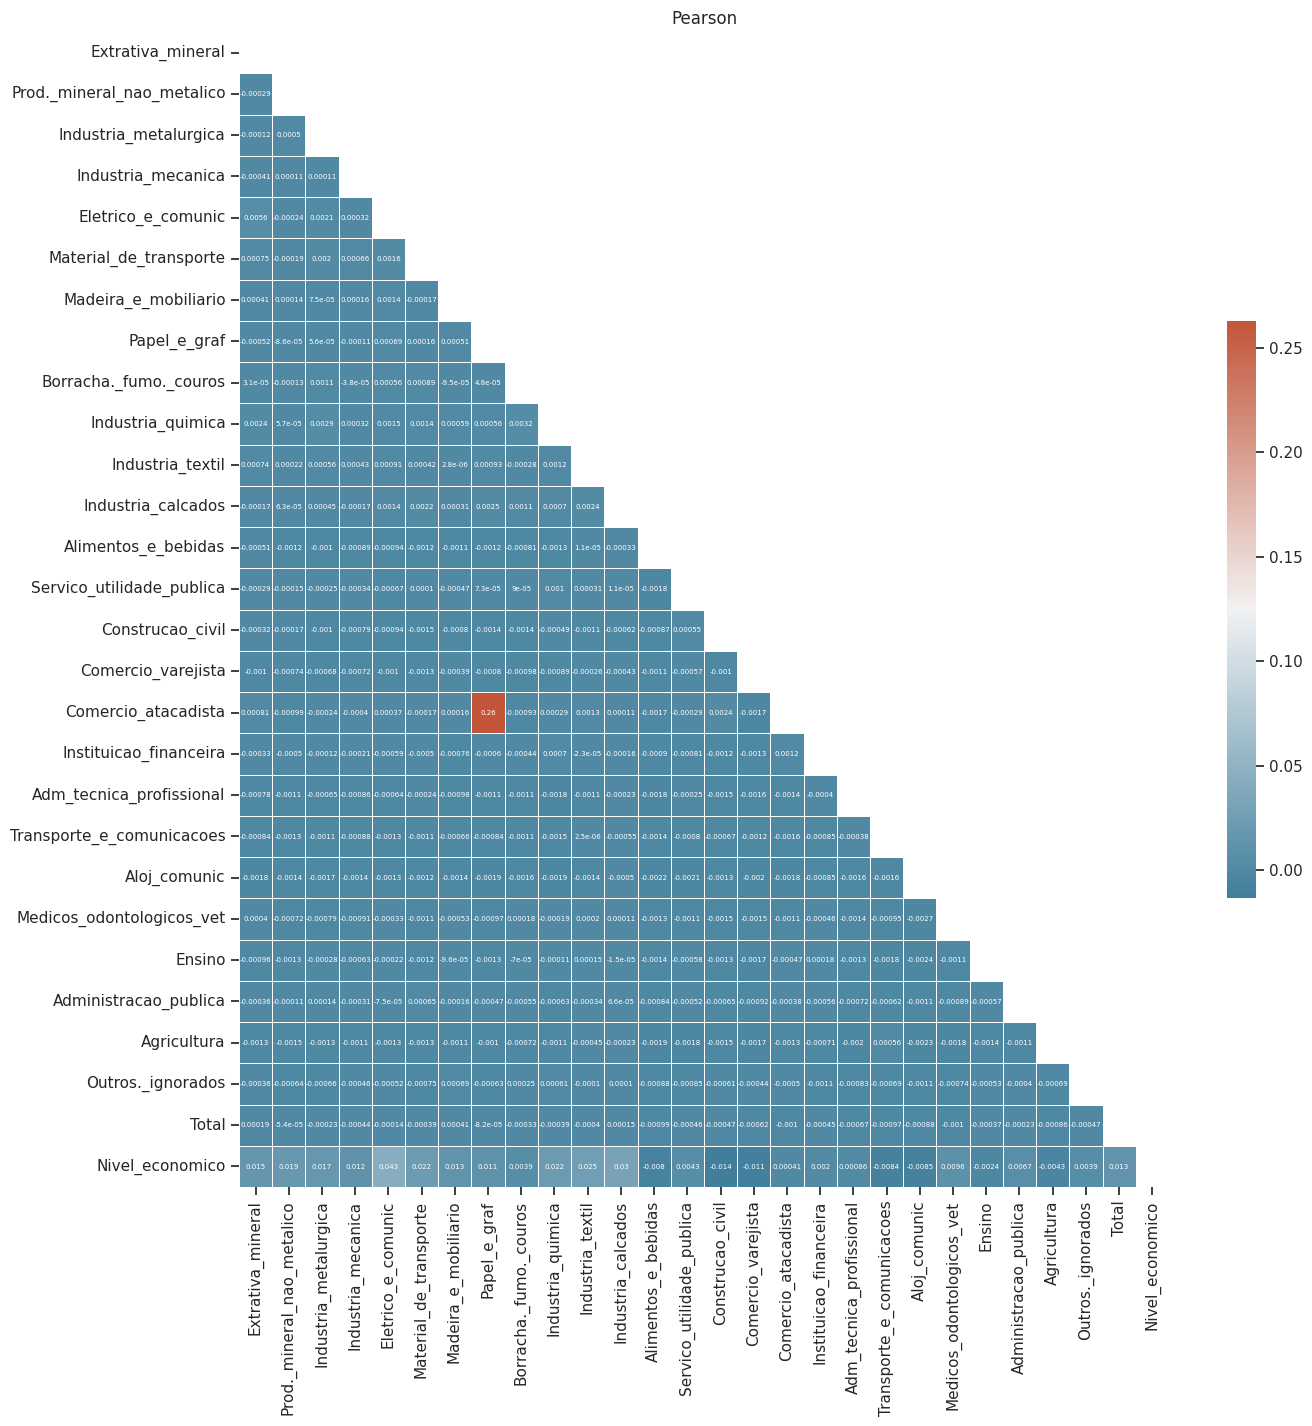

In [44]:
#@markdown Pearson Correlation

plt.figure(figsize=(15, 15))

corr_method = 'pearson'

corr = df.iloc[:, 6:].corr(method=corr_method)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            cmap=cmap,
            annot=True,
            annot_kws={"size": 5})

plt.title(corr_method.capitalize())

plt.show()

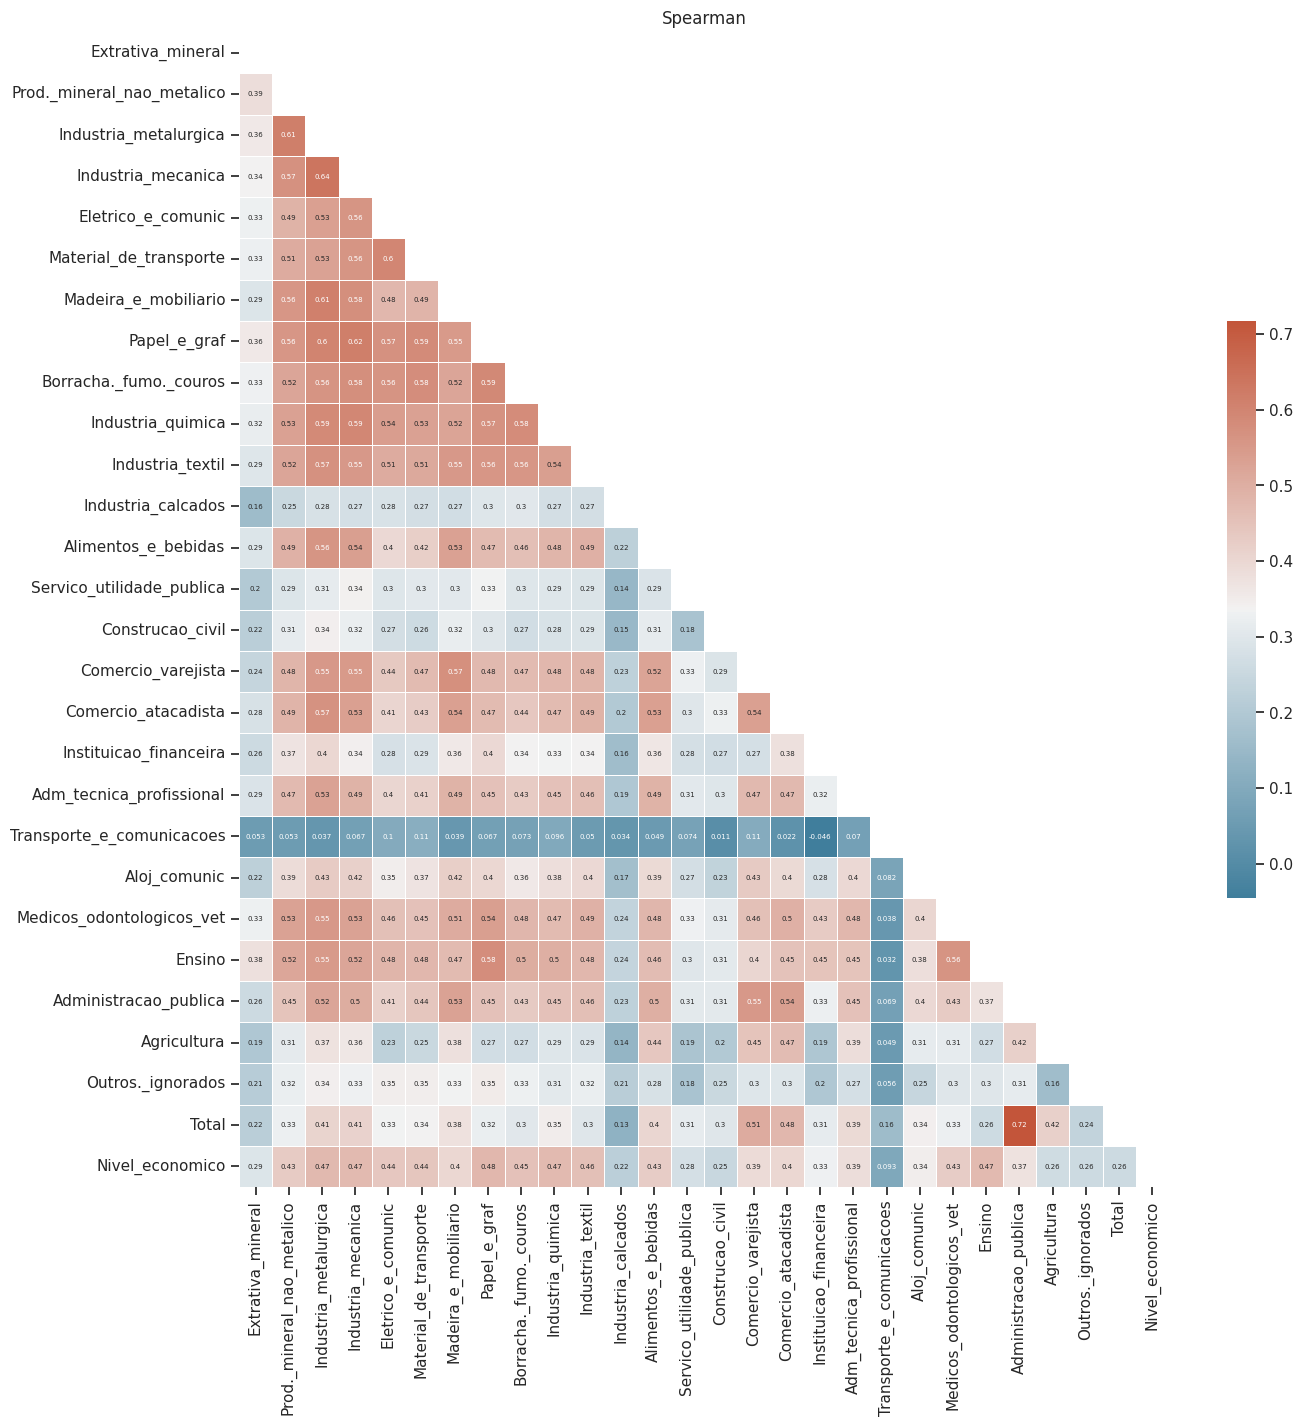

In [45]:
#@markdown Spearman Correlation

plt.figure(figsize=(15, 15))

corr_method = 'spearman'

corr = df.iloc[:, 6:].corr(method=corr_method)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            cmap=cmap,
            annot=True,
            annot_kws={"size": 5})

plt.title(corr_method.capitalize())

plt.show()

## **Country Analysis**

In [46]:
#@title RadViz Function
def create_anchor_coordinates(num_features: int, r: int = 1):
  """
  Function that return the anchor coordinates
  """

  x_coordinates = [r * np.cos((2 * np.pi * i) / num_features)for i in range(1, num_features + 1)]
  y_coordinates = [r * np.sin((2 * np.pi * i) / num_features)for i in range(1, num_features + 1)]

  coordinates = np.zeros((num_features, 2))

  coordinates[:, 0] = np.array(x_coordinates)
  coordinates[:, 1] = np.array(y_coordinates)

  return coordinates


def create_circle_coordinates(r: int = 1,
                              num_coordinates: int = 200):
  """
  Function that return the circle coordinates
  """
  center = (0, 0)
  theta = np.linspace(0, 2 * np.pi, num_coordinates)
  x = center[0] + r * np.cos(theta)
  y = center[1] + r * np.sin(theta)

  coordinates = np.zeros((num_coordinates, 2))

  coordinates[:, 0] = x
  coordinates[:, 1] = y

  return coordinates


def min_max_normalize(X: np.ndarray):
  """
  Function that normalize data
  """
  x_min = np.min(X, axis=0)
  x_max = np.max(X, axis=0)

  X_norm = (X - x_min) / (x_max - x_min)

  return x_min, x_max, X_norm


def create_projected_coordinates(data: np.ndarray,
                                 anchors: np.ndarray):
  """
  Function that create projected coordinates
  """
  X = data.copy()

  _, _, X = min_max_normalize(X)

  X_projected = []
  x_anchors = anchors[:, 0]
  y_anchors = anchors[:, 1]

  for x in X:
    sum_values = np.sum(x)
    Xp = np.sum(x * x_anchors) / sum_values
    Yp = np.sum(x * y_anchors) / sum_values

    X_projected.append([Xp, Yp])

  return np.array(X_projected)


def radviz_plot(dataframe: pd.DataFrame,
                target: str,
                dataset_name: str = "",
                width: int = 800,
                palette: list = px.colors.diverging.Portland,
                line_width: float = 0.,
                opacity: float = 0.6):
  """
  Function that make RadViz Plot
  """

  dataframe_without_target = dataframe.drop(columns=[target])
  features_names = list(dataframe_without_target.keys())

  X = dataframe_without_target.to_numpy()
  Y = dataframe[target].to_numpy()

  if not np.issubdtype(Y.dtype, np.integer):
    raise ValueError("Labels must be in numeric format")

  num_anchors = X.shape[1]

  anchors_coordinates = create_anchor_coordinates(num_anchors)

  circle_coordinates = create_circle_coordinates()

  projected_coordinates = create_projected_coordinates(X, anchors_coordinates)

  # Create Figure
  fig = go.Figure()

  # Create Circle Plot
  CIRCLE_TRACE_IDX = 0
  fig.add_trace(
      go.Scatter(
          x=circle_coordinates[:, 0],
          y=circle_coordinates[:, 1],
          mode='lines',
          marker=dict(
              color='grey',
          ),
          showlegend=False
      )
  )

  # Create Anchors Coordinatas
  ANCHORS_TRACE_IDX = 1
  fig.add_trace(
      go.Scatter(
          x=anchors_coordinates[:, 0],
          y=anchors_coordinates[:, 1],
          mode='markers+text',
          marker=dict(
              color='grey',
              size=10
          ),
          text=features_names,
          textposition='top center',
          showlegend=False
      )
  )

  # Put the data and labels in the figure
  ALL_LABELS_TRACE_IDX = 2
  for idx, label in enumerate(np.unique(Y)):
    label_idx = np.where(Y == label, True, False)
    aux_data =  projected_coordinates[label_idx]

    fig.add_trace(
        go.Scatter(
            name=f'Label {label}',
            x=aux_data[:, 0],
            y=aux_data[:, 1],
            mode='markers',
            marker_color=palette[int(idx)],
            marker=dict(
                opacity=opacity,
                line_width=line_width
            )
        )
    )


  buttons = [
      dict(
          args=[{'visible':[True, True, True, True, True]}],
          label="Show all labels",
          method="update"
      ),
  ]

  num_classes = len(np.unique(Y))
  num_traces = [False] * (ALL_LABELS_TRACE_IDX + num_classes + 1)

  num_traces[CIRCLE_TRACE_IDX] = True
  num_traces[ANCHORS_TRACE_IDX] = True

  for idx, label in enumerate(np.unique(Y)):

    visible = num_traces.copy()
    visible[ALL_LABELS_TRACE_IDX + idx] = True

    button = dict(
        args=[{'visible':visible}],
        label=f"Label {label}",
        method="update"
    )

    buttons.append(button)


  fig.update_layout(
        updatemenus=[
          dict(
              type="dropdown",
              direction="down",
              x=1.0,
              y=1.10,
              xanchor='left',
              yanchor='top',
              buttons=buttons,
              showactive=True
          )
      ],
      title=f'RadViz Plot - {dataset_name}' if dataset_name != "" else "RadViz Plot",
      width=width,
      height=width,
      template='plotly_white'
  )

  fig.update_xaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)
  fig.update_yaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)
  fig.show()

In [47]:
#@title Feature Importance

k_features = 5 #@param
X = df.iloc[:,6:].drop(columns=['Nivel_economico'])
Y = df['Nivel_economico']


mi = mutual_info_classif(X, Y)
mi_frame = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)
display(mi_frame.iloc[:k_features])
print()


radviz_plot(dataframe=df.iloc[:, 6:],
            target='Nivel_economico',
            dataset_name='RAIS FREQ')

,Mutual_information
Industria_mecanica,0.152115
Industria_metalurgica,0.150286
Ensino,0.149862
Material_de_transporte,0.149193
Papel_e_graf,0.142883


## **Region Analyze**

In [48]:
#@title Radviz
region = 'CentroOeste' #@param
k_features = 5 #@param

aux_frame = df[df['Regiao'] == region]
aux_frame = aux_frame.iloc[:, 6:]

X = aux_frame.drop(columns=['Nivel_economico'])
Y = aux_frame['Nivel_economico']

mi = mutual_info_classif(X, Y)
mi_frame = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)
display(mi_frame.iloc[:k_features])

radviz_plot(dataframe=aux_frame,
            target='Nivel_economico',
            dataset_name='RAIS FREQ')

,Mutual_information
Instituicao_financeira,0.139335
Administracao_publica,0.122155
Material_de_transporte,0.120879
Ensino,0.120518
Prod._mineral_nao_metalico,0.120146


In [49]:
#@title Radviz
region = 'Sul' #@param
k_features = 5 #@param

aux_frame = df[df['Regiao'] == region]
aux_frame = aux_frame.iloc[:, 6:]

X = aux_frame.drop(columns=['Nivel_economico'])
Y = aux_frame['Nivel_economico']

mi = mutual_info_classif(X, Y)
mi_frame = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)
display(mi_frame.iloc[:k_features])


radviz_plot(dataframe=aux_frame,
            target='Nivel_economico',
            dataset_name='RAIS FREQ')

,Mutual_information
Ensino,0.153576
Material_de_transporte,0.133967
Prod._mineral_nao_metalico,0.122772
Papel_e_graf,0.113165
Borracha._fumo._couros,0.106689


## **State Analysis**

In [50]:
#@title Feature Importance and Radviz
plt.figure(figsize=(12, 8))
state = 'PE' #@param
k_features = 5 #@param

aux_frame = df[df['Estado'] == state]
aux_frame = aux_frame.iloc[:, 6:]

X = aux_frame.drop(columns=['Nivel_economico'])
Y = aux_frame['Nivel_economico']

mi = mutual_info_classif(X, Y)
mi_frame = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)
display(mi_frame.iloc[:k_features])

radviz_plot(dataframe=aux_frame,
            target='Nivel_economico',
            dataset_name='RAIS FREQ')

,Mutual_information
Ensino,0.111056
Eletrico_e_comunic,0.103835
Medicos_odontologicos_vet,0.095630
Borracha._fumo._couros,0.093769
Papel_e_graf,0.091429


<Figure size 1200x800 with 0 Axes>

In [51]:
#@title Feature Importance and Radviz
plt.figure(figsize=(12, 8))
state = 'RN' #@param
k_features = 5 #@param

aux_frame = df[df['Estado'] == state]
aux_frame = aux_frame.iloc[:, 6:]

X = aux_frame.drop(columns=['Nivel_economico'])
Y = aux_frame['Nivel_economico']

mi = mutual_info_classif(X, Y)
mi_frame = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)
display(mi_frame.iloc[:k_features])

radviz_plot(dataframe=aux_frame,
            target='Nivel_economico',
            dataset_name='RAIS FREQ')

,Mutual_information
Borracha._fumo._couros,0.132849
Material_de_transporte,0.111452
Industria_metalurgica,0.095969
Industria_textil,0.089044
Madeira_e_mobiliario,0.084866


<Figure size 1200x800 with 0 Axes>

## **Feature Importances**

In [52]:
#@title Evaluate feature performance - All Regions
X = df.iloc[:, 6:].drop(columns=['Nivel_economico'])
Y = df['Nivel_economico']

clf = RandomForestClassifier(random_state=0)
skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(clf, X, Y, cv=skf)

print(f'Accuracy :: {scores.mean():.4} ± {scores.std():.4}')

Accuracy :: 0.557 ± 0.03579


In [53]:
#@title Evaluate feature performance in each Region
region_and_scores = {}
region_feature_importances = {}

num_samples_by_region = []

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for region in tqdm(df['Regiao'].unique()):

    aux_frame = df[df['Regiao'] == region]
    X = aux_frame.iloc[:, 6:].drop(columns=['Nivel_economico'])
    Y = aux_frame['Nivel_economico']

    clf = RandomForestClassifier(random_state=0)
    skf = StratifiedKFold(n_splits=5)

    scores = cross_val_score(clf, X, Y, cv=skf)

    region_and_scores[region] = scores

    num_samples_by_region.append(len(Y))

    clf.fit(X, Y)
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    region_feature_importances[region] = feature_importance_df


for region in region_and_scores:
  scores = region_and_scores[region]
  print(f'{region} :: {scores.mean():.4} ± {scores.std():.4}')

  0%|          | 0/5 [00:00<?, ?it/s]

Norte :: 0.708 ± 0.0172
Nordeste :: 0.6456 ± 0.01954
Sudeste :: 0.64 ± 0.05027
Sul :: 0.5644 ± 0.05744
CentroOeste :: 0.5928 ± 0.04079


In [54]:
#@title Feature Importance different States
print('Nordeste')
pprint(region_feature_importances['Nordeste'])

print('\nSudeste')
pprint(region_feature_importances['Sudeste'])

Nordeste
                       Feature  Importance
15          Comercio_varejista    0.069954
23       Administracao_publica    0.064291
26                       Total    0.062368
20                Aloj_comunic    0.058131
17      Instituicao_financeira    0.056978
19   Transporte_e_comunicacoes    0.056952
18    Adm_tecnica_profissional    0.056702
21   Medicos_odontologicos_vet    0.053205
14            Construcao_civil    0.050161
24                 Agricultura    0.049178
22                      Ensino    0.047230
12         Alimentos_e_bebidas    0.041907
16         Comercio_atacadista    0.039654
13   Servico_utilidade_publica    0.036165
7                 Papel_e_graf    0.033214
10            Industria_textil    0.031742
2        Industria_metalurgica    0.030730
1   Prod._mineral_nao_metalico    0.026840
3           Industria_mecanica    0.025427
9            Industria_quimica    0.020697
6         Madeira_e_mobiliario    0.018617
0            Extrativa_mineral    0.016538
25

In [55]:
#@title Relação Número de Amostras por Região e poder preditivo
colors = ['blue', 'red', 'orange', 'green', 'black']

fig = go.Figure()

for i, region in enumerate(region_and_scores):
  score = region_and_scores[region].mean()

  fig.add_trace(
      go.Scatter(
          x=[score],
          y=[num_samples_by_region[i]],
          mode='markers',
          marker_color=colors[i],
          name=region
      )
  )

fig.update_layout(
  title='Número de Cidades de cada Região por Auracia Media',
  yaxis_title='Número de Cidades',
  xaxis_title='Acuracia',
  width=800,
  height=500,
  template='plotly_white'
)
fig.show()

In [56]:
#@title Evaluate feature performance in each State

# Suprimir todos os warnings ou warnings específicos (exemplo: ConvergenceWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    state_and_scores = {}
    state_feature_importances = {}
    num_samples_by_state = []
    for state in tqdm(df['Estado'].unique()):

      if state != 'DF':
        aux_frame = df[df['Estado'] == state]
        X = aux_frame.iloc[:, 6:].drop(columns=['Nivel_economico'])
        Y = aux_frame['Nivel_economico']

        clf = RandomForestClassifier(random_state=0)
        skf = StratifiedKFold(n_splits=5)

        scores = cross_val_score(clf, X, Y, cv=skf)

        state_and_scores[state] = scores

        num_samples_by_state.append(len(Y))


        clf.fit(X, Y)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': clf.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        state_feature_importances[state] = feature_importance_df

for state in state_and_scores:
  scores = state_and_scores[state]
  print(f'{state} :: {scores.mean():.4} ± {scores.std():.4}')

  0%|          | 0/27 [00:00<?, ?it/s]

RO :: 0.6722 ± 0.05597
AC :: 0.73 ± 0.06782
AM :: 0.7103 ± 0.03377
RR :: 0.8 ± 0.1633
PA :: 0.668 ± 0.1067
AP :: 0.6333 ± 0.06667
TO :: 0.8333 ± 0.03644
MA :: 0.6431 ± 0.05561
PI :: 0.7827 ± 0.03128
CE :: 0.6526 ± 0.05579
RN :: 0.5547 ± 0.08863
PB :: 0.7376 ± 0.04663
PE :: 0.5685 ± 0.05082
AL :: 0.6332 ± 0.04493
SE :: 0.5686 ± 0.04524
BA :: 0.6197 ± 0.04856
MG :: 0.5927 ± 0.03508
ES :: 0.7325 ± 0.07986
RJ :: 0.5719 ± 0.07795
SP :: 0.748 ± 0.01868
PR :: 0.6016 ± 0.04466
SC :: 0.6292 ± 0.03479
RS :: 0.6686 ± 0.02492
MS :: 0.5683 ± 0.0702
MT :: 0.6815 ± 0.07626
GO :: 0.5945 ± 0.08004


In [57]:
#@title Feature Importance different States
print('Minas Gerais')
pprint(state_feature_importances['MG'])

print('\nSão Paulo')
pprint(state_feature_importances['SP'])

Minas Gerais
                       Feature  Importance
23       Administracao_publica    0.070346
21   Medicos_odontologicos_vet    0.061260
26                       Total    0.054503
12         Alimentos_e_bebidas    0.054276
19   Transporte_e_comunicacoes    0.050247
20                Aloj_comunic    0.049898
18    Adm_tecnica_profissional    0.048018
17      Instituicao_financeira    0.047446
24                 Agricultura    0.045492
15          Comercio_varejista    0.045485
14            Construcao_civil    0.044511
22                      Ensino    0.043872
9            Industria_quimica    0.036177
16         Comercio_atacadista    0.035571
4           Eletrico_e_comunic    0.033014
10            Industria_textil    0.032177
0            Extrativa_mineral    0.031869
6         Madeira_e_mobiliario    0.030919
1   Prod._mineral_nao_metalico    0.030830
13   Servico_utilidade_publica    0.026314
2        Industria_metalurgica    0.026085
8       Borracha._fumo._couros    0.02198

In [58]:
#@title Relação Número de Amostras por Estado e poder preditivo

fig = go.Figure()

for i, state in enumerate(state_and_scores):
  score = state_and_scores[state].mean()

  fig.add_trace(
      go.Scatter(
          x=[score],
          y=[num_samples_by_state[i]],
          mode='markers',
          marker=dict(
              size=10,
              line_width=1,
              color='blue'
          ),
          showlegend=False
      )
  )

fig.update_layout(
  title='Número de Cidades de cada Região por Auracia Media',
  yaxis_title='Número de Cidades',
  xaxis_title='Acuracia',
  width=1000,
  height=700,
  template='plotly_white'
)
fig.show()